# Определение перспективного тарифа для телеком-компании

<a id='TOC'></a>

Заказчик - оператор сотовой связи. 

Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Необходимо выяснить, какой тариф приносит больше дохода. Цель - корректировка рекламного бюджета. 

Предварительный анализ тарифов проводится на небольшой выборке клиентов (500 пользователей): уточним их особенности и параметры использования услуг связи за 2018 год. Исходя из поведения клиентов определим, какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
    - 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
    - 2. сообщение: 3 рубля; 
    - 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
    - 1. минута разговора: 1 рубль; 
    - 2. сообщение: 1 рубль; 
    - 3. 1 Гб интернет-трафика: 150 рублей.
    
*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

**Описание данных**

Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Изучение общей информации о данных 

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import math

%config InlineBackend.figure_format = 'retina' # добавим четкости графикам 
import matplotlib # настроим стиль отображения графиков
matplotlib.style.use('seaborn-dark') 
from pylab import rcParams # зададим размеры всех графиков
rcParams['figure.figsize'] = 8, 6
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # скроем предупреждения о будущих изменениях

Загрузим данные и ознакомимся с ними.

### Данные звонков.

In [2]:
# при чтении преобразуем дату в формат datetime
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
display (calls.head(10))
display (calls.info())
calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


### Данные по интернету.

In [3]:
# в качестве индекса сразу укажем первый столбец
# дату преобразуем в формат datetime
internet = pd.read_csv('/datasets/internet.csv', index_col=[0], parse_dates=['session_date']) 
display (internet.head())
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


### Данные по сообщениям

In [4]:
# дату преобразуем в формат datetime
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
display (messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Тарифы

In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display (tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Данные пользователей

In [6]:
# дату преобразуем в формат datetime
users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
display (users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Вывод

В таблицах представлены данные по звонкам, сообщениям, интернет-трафику, информация о пользователях и тарифах. Пропуски присутствуют только в столбце `churn_date` с информацией о дате прекращения использования тарифа. Пропуск в данном столбце означает, что клиент продолжает пользоваться тарифом на момент выгрузки данных.

## Предобработка данных

### Таблица звонков

Изучим представленный в данных период

In [7]:
calls['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

В столбце данные за весь 2018 год.

Округлим данные длинны звонков с соответствии с условиями оператора (до минуты в большую сторону). 
Переведем их в формат целых чисел (подойдет uint8, так как отрицательных значений нет, а максимальное менее 255). Рассмотрим гистограмму значений.

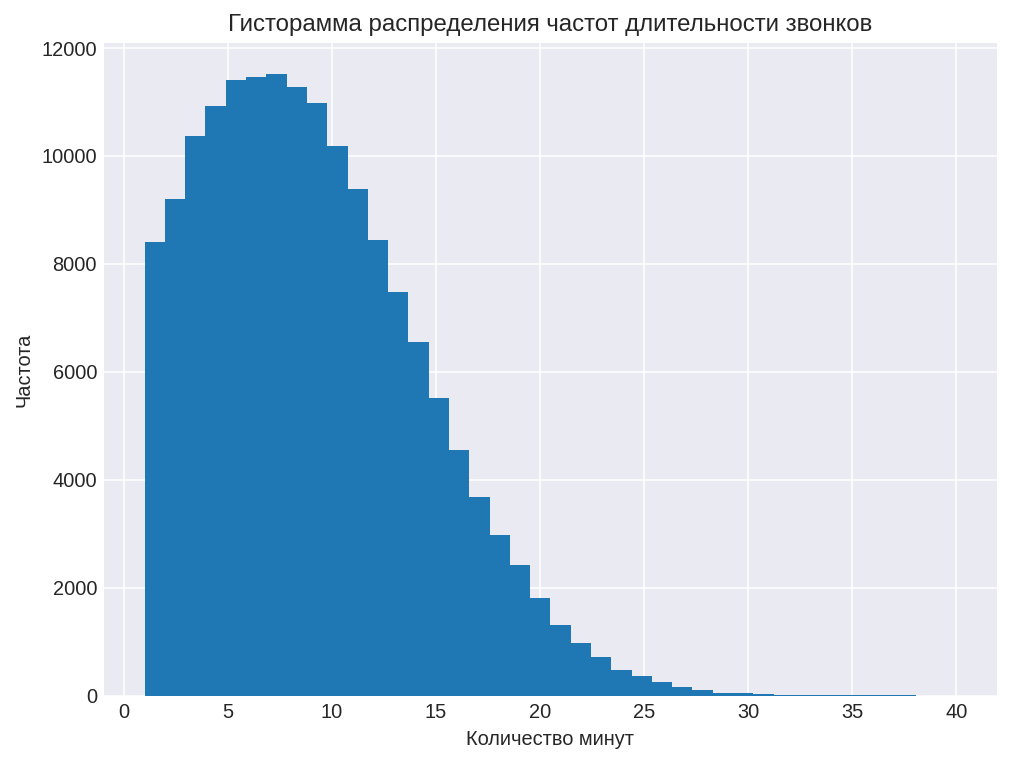

In [8]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('uint8') # округлим минуты в большую сторону по условиям оператора и переведем в целочисленный формат
calls['duration'].hist(range=(1, 40), bins=40) ; # рассмотрим распределение значений на гистограмме 
plt.xlabel('Количество минут')
plt.ylabel('Частота')
plt.title('Гисторамма распределения частот длительности звонков');

Во избежании путаницы с `id`, переименуем колонку, чтобы точно понимать, об уникальном номере звонка, сообщения или интернет-сессии идет речь. 

Убедимся в отсутствии дубликатов.

In [9]:
calls = calls.rename(columns={'id':'call_id'})
calls[calls.duplicated()]

,call_id,call_date,duration,user_id


### Таблица интернета

Переименуем столбец `id`, чтобы понимать, что здесь речь идет об идентификаторе интернет-сессии.

In [10]:
internet = internet.rename(columns={'id':'session_id'}) # переименуем столбец id с целью минимизации ошибок

Изучим представленный временной период

In [11]:
internet['session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

В столбце данные за весь 2018 год. 

Посмотрим на распределение значений интернет-трафика с помощью гистограммы.

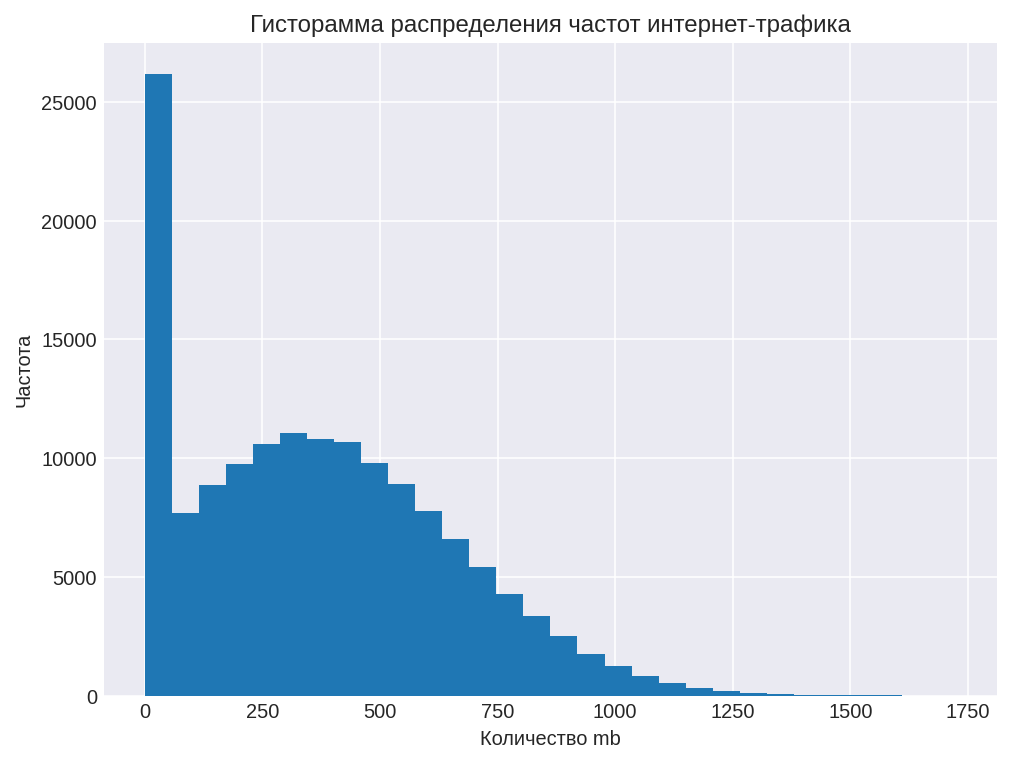

In [12]:
internet['mb_used'].hist(bins=30)
plt.xlabel('Количество mb')
plt.ylabel('Частота')
plt.title('Гисторамма распределения частот интернет-трафика');

Множество сессий с нулевым трафиком могут быть следствием фоновой (служебной) активности подключенных к интернету устройств, либо неудачными попытками подключения.

Убедимся в отстутсвии дубликатов.

In [13]:
internet[internet.duplicated()]

,session_id,mb_used,session_date,user_id


### Таблица сообщений

Переименуем столбец `id` во избежании путаницы.

In [14]:
messages = messages.rename(columns={'id':'message_id'}) # переименуем столбец id с целью минимизации ошибок

Изучим представленный в данных период

In [15]:
messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Данные по трафику представлены за весь 2018 год, кроме 01.01.2018

Убедимся в отсутствии дубликатов.

In [16]:
messages[messages.duplicated()]

,message_id,message_date,user_id


### Таблица пользователей

Изучим представленный временной период в признаках `reg_date`и `churn_date` 

In [17]:
print ('Данные регистраций')
display(users['reg_date'].describe())
print ('Данные оттока')
users['churn_date'].describe()

Данные регистраций


count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

Данные оттока


count                      38
unique                     33
top       2018-10-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

Регистрация пользователей проходила в период с 01.01.2018 по 31.12.2018. Тогда как период оттока с 17.08.2018 по 30.12.2018. То есть первый пользователь, зарегистрировавшийся в изучаемый период, ушел лишь 17.08.2018. Посмотрим, сколько он был клиентом оператора (сравним дату регистрации и оттока)

In [18]:
users.query('churn_date == "2018-08-17"')['churn_date'] - users.query('churn_date == "2018-08-17"')['reg_date']

254   225 days
dtype: timedelta64[ns]

То есть минимальный срок использования услуг оператора составляет 225 дней.

Убедимся с отсутствии дубликатов.

In [19]:
users[users.duplicated()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


### Таблица тарифов

Приведем название столбца `tariff_name` в соответствии с его наименованием в таблице пользователей. 

In [20]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

Поскольку подсчет интернет-трафика оператором ведется в гигабитах, переведем значения столбца включенного в тариф трафика и переименуем его. 

In [21]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})

### Вывод

Во всех таблицах строки с информацией о датах и времени преобразованы в датовременной формат. Столбцы, для которых нам необходимы округленные значения, приведены к целочисленному формату, выбранному исходя из принципов экономии ресурсов памяти.

Колонки переименованы в соответствии с логикой представленной в них информации. 

С таблицах нет дубликатов. Пропущенные значения в столбце с датой прекращения использования тарифа оставлены без изменений.

Ошибки, созданные при формировании данных и выгрузке в виде столбца, дублирующего индексы строк, устранены. 

## Анализ данных каждого пользователя

### Количество сделанных звонков и израсходованных минут разговора по месяцам

Добавим столбец с номером месяца и сгруппируем данные по звонкам для каждого пользователя по месяцам.

In [22]:
calls['month'] = calls['call_date'].dt.month
# посчитаем для каждого пользователя длительность звонков и их количество по месяцам
calls_stat = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum','count']).reset_index() 
calls_stat.columns=['user_id', 'month', 'tot_duration', 'calls_count'] # избавимся от двухэтажных названий столбцов
display (calls_stat.info())
calls_stat.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3174 non-null   int64  
 1   month         3174 non-null   int64  
 2   tot_duration  3174 non-null   float64
 3   calls_count   3174 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 99.3 KB


None

,user_id,month,tot_duration,calls_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
5,1000,10,350.0,57
6,1000,11,338.0,43
7,1000,12,333.0,46
8,1001,11,430.0,59
9,1001,12,414.0,63


В полученной таблице `calls_stat` представлена информация об общей продолжительности и количестве звонков каждого пользователя за каждый месяц использования тарифа.

### Количество отправленных сообщений по месяцам

Добавим столбец с месяцем и сгруппируем данные о количестве сообщений каждого пользователя по месяцам.

In [23]:
messages['month'] = messages['message_date'].dt.month
# посчитаем для каждого пользователя количество сообщений по месяцам
messages_stat = (messages
                 .pivot_table(index=['user_id', 'month'], values='message_id', aggfunc='count')
                 .reset_index()
                 .rename(columns={'message_id':'message_count'})) 
display (messages_stat.info())
messages_stat.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        2717 non-null   int64
 1   month          2717 non-null   int64
 2   message_count  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


None

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


В полученной таблице `messages_stat` представлена информация о количестве сообщений каждого пользователя по месяцам.

### Объем израсходованного интернет-трафика по месяцам

Создадим столбец с месяцем интернет-сессии и посчитаем объем использования трафика в месяц для каждого пользователя.

In [24]:
internet['month'] = internet['session_date'].dt.month
# посчитаем количество трафика для каждого пользователя по месяцам
internet_stat = (internet
                 .pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
                 .reset_index()
                 .rename(columns={'mb_used': 'month_mb_used'})) 
internet_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3203 non-null   int64  
 1   month          3203 non-null   int64  
 2   month_mb_used  3203 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 75.2 KB


Переведем данные в гигабиты и округлим суммы трафика за месяц до гб в соответствии с условиями оператора. Удалим ненужный столбец с мегабитами.

In [25]:
internet_stat['month_gb_used'] = (internet_stat['month_mb_used']/1024).apply(np.ceil).astype('int') 
internet_stat = internet_stat.drop(columns='month_mb_used', axis=1)
internet_stat.head()

,user_id,month,month_gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


В полученной таблице `internet_stat` информация о количестве трафика в гб для каждого пользователя за каждый месяц. 

### Помесячная выручка с каждого пользователя

Объединим полученные таблицы со статистикой по пользователям и месяцам. 

In [26]:
calls_message_internet_stat = calls_stat.merge(messages_stat, on=['user_id', 'month'], how='outer').merge(
    internet_stat, on=['user_id', 'month'], how='outer') # объединим сводные таблицы звонков, смс и трафика
calls_message_internet_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3214 non-null   int64  
 1   month          3214 non-null   int64  
 2   tot_duration   3174 non-null   float64
 3   calls_count    3174 non-null   float64
 4   message_count  2717 non-null   float64
 5   month_gb_used  3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


В объединенной таблице со статистикой образовались пропущенные значения, которые означают, что в этом месяце пользователь не делал звонков/ не отправлял сообщения / не пользовался интернетом. Заменим их на ноль. 

In [27]:
calls_message_internet_stat = calls_message_internet_stat.fillna(0) 

Соединим данные пользователей с условиями тарифов. Создадим общую таблицу, включающую статистику по вызовам, смс и трафику, пользователям и условиям тарифа. 

In [28]:
users_tariffs = users[['user_id','tariff','city']].merge(tariffs, on='tariff', how='left') # соединим таблицу пользователей и условий тарифов
df = calls_message_internet_stat.merge(users_tariffs, on='user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   tot_duration           3214 non-null   float64
 3   calls_count            3214 non-null   float64
 4   message_count          3214 non-null   float64
 5   month_gb_used          3214 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   gb_per_month_included  3214 non-null   float64
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
dtypes: f

Изменим типы значений в полученной таблице

In [29]:
df['tot_duration'] = df['tot_duration'].astype('uint16') # uint16, поскольку максимальное значение 1673, отрицательных значений нет.
df['calls_count'] = df['calls_count'].astype('uint8') # uint8, поскольку максимальное значение 244, отрицательных значений нет
df['message_count'] = df['message_count'].astype('uint8') # uint8, поскольку максимальное значение 224, отрицательных значений нет
df['month_gb_used'] = df['month_gb_used'].astype('uint8') # uint8, поскольку максимальное значение 49, отрицательных значений нет
df['gb_per_month_included'] = df['gb_per_month_included'].astype('uint8') # uint8, поскольку максимальное значение 30, отрицательных значений нет

Напишем функцию, которая будет возвращать выручку оператора в зависимости от количества потраченных минут разговора, сообщений и трафика в месяц с учетом включенных в пакет услуг и базовой стоимости тарифа. 

In [30]:
def profit(data):
    if (data['tot_duration'] - data['minutes_included']) > 0:
        profit_calls = (data['tot_duration'] - data['minutes_included']) * data['rub_per_minute'] 
    else:
        profit_calls = 0
    if (data['message_count'] - data['messages_included']) > 0:
        profit_messages = (data['message_count'] - data['messages_included']) * data['rub_per_message']
    else:
        profit_messages = 0
    if (data['month_gb_used'] - data['gb_per_month_included']) > 0:
        profit_internet = (data['month_gb_used'] - data['gb_per_month_included']) * data['rub_per_gb']
    else:
        profit_internet = 0
    return profit_calls + profit_messages + profit_internet + data['rub_monthly_fee']

In [31]:
df['profit'] = df.apply(profit, axis=1) # применим полученную функцию 
df.head(10)

,user_id,month,tot_duration,calls_count,message_count,month_gb_used,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,159,22,22,3,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
1,1000,6,172,43,60,23,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
2,1000,7,340,47,75,14,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
3,1000,8,408,52,81,14,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
4,1000,9,466,58,57,15,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
5,1000,10,350,57,73,15,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
6,1000,11,338,43,58,15,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
7,1000,12,333,46,70,10,ultra,Краснодар,1000,30,3000,1950,150,1,1,1950
8,1001,11,430,59,0,18,smart,Москва,50,15,500,550,200,3,3,1150
9,1001,12,414,63,0,14,smart,Москва,50,15,500,550,200,3,3,550


### Вывод

Исходя из полученных данных, нам известно о каждом пользователе и каждом месяце использования тарифа:
* количество минут разговора
* количество сделанных звонков
* количество отправленных сообщений
* объем использованного интернет-трафика
* помесячная выручка с каждого пользователя. 

## Анализ поведения пользователей в зависимости от используемого тарифа.

### Среднее, дисперсия, квадратичное отклонение

Разобъем сет на два подсета в зависимости от использумого тарифа, чтобы определить характерные особенности каждой группы. 

In [32]:
df_smart = (df.query('tariff == "smart"')
            .drop(columns=['messages_included', 'gb_per_month_included', 'minutes_included', 
                           'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']))
df_smart.describe()

,user_id,month,tot_duration,calls_count,message_count,month_gb_used,profit
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,58.463437,33.384029,16.328847,1289.973531
std,146.119496,2.920316,190.313730,25.939858,28.227876,5.747061,818.404367
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,282.000000,40.000000,10.000000,13.000000,550.000000
50%,1239.000000,9.000000,422.000000,60.000000,28.000000,17.000000,1023.000000
75%,1376.000000,11.000000,545.000000,76.000000,51.000000,20.000000,1750.000000
max,1499.000000,12.000000,1435.000000,198.000000,143.000000,38.000000,6770.000000


Пользователи тарифа 'Smart' в месяц:
- разговаривают в среднем 418 минут / 422 минуты по медиане, 
- совершают в среднем 58,5 звонков / 60 звонков по медиане, 
- пишут в среднем 33,4 сообщения / 28 по медиане, 
- тратят в среднем 16,3 гб / 17 по медиане,
- приносят оператору связи в среднем 1290 руб. выручки / 1023 руб. по медиане.

In [33]:
df_ultra = (df.query('tariff == "ultra"')
            .drop(columns=['messages_included', 'gb_per_month_included', 'minutes_included', 
                           'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']))
df_ultra.describe()

,user_id,month,tot_duration,calls_count,message_count,month_gb_used,profit
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,73.392893,49.363452,19.494416,2070.152284
std,140.694908,2.871762,317.606098,43.916853,47.804457,9.853511,376.187114
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,284.000000,41.000000,6.000000,12.000000,1950.000000
50%,1277.000000,9.000000,518.000000,74.000000,38.000000,19.000000,1950.000000
75%,1381.000000,11.000000,752.000000,104.000000,79.000000,27.000000,1950.000000
max,1495.000000,12.000000,1673.000000,244.000000,224.000000,49.000000,4800.000000


Пользователи тарифа 'Ultra' в месяц
- разговаривают в среднем 526,6 минут / 518 минут по медиане, 
- совершают в среднем 73,4 звонка / 74 по медиане, 
- пишут в среднем 49,4 сообщения / 38 по медиане, 
- тратят в среднем 19,5 гб / 19 по медиане,
- приносят оператору связи в среднем 2070 руб. выручки / 1950 по медиане.

In [34]:
print ('Количество пользователей тарифа \"Smart\":', df_smart['user_id'].nunique())
print ('Количество пользователей тарифа \"Ultra\":', df_ultra['user_id'].nunique())

Количество пользователей тарифа "Smart": 350
Количество пользователей тарифа "Ultra": 148


В данных более 2/3 пользователей подключены к тарифу "Smart" и менее 1/3 - к "Ultra".

Поскольку у нас достаточно большое число данных (более 100 в каждой выборке), мы можем предположить, что, согласно Центральной предельной теореме, множество этих независимых случайных величин дают близкое к нормальному распределение. 

Посчитаем основные числовые характеристики выборок.
Для большей наглядности очистим сеты от дополнительных колонок.

In [35]:
ultra = df_ultra.drop(columns=['user_id', 'month'])
smart = df_smart.drop(columns=['user_id', 'month'])

Посчитаем среднее по оставшимся параметрам для пользователей каждого тарифа.

In [36]:
ultra_mean = ultra.mean()
smart_mean = smart.mean()

Вычислим дисперсию

In [37]:
ultra_var = np.var(ultra)
smart_var = np.var(smart)

Найдем квадратичное отклонение

In [38]:
ultra_std = ultra.std()
smart_std = smart.std()

Сведем получившиеся сведения в одну таблицу для удобства сравнения. 

In [39]:
ultra_smart_stat = df.groupby('tariff')[['tot_duration', 'calls_count', 'message_count', 'month_gb_used', 'profit']].agg(
    ['mean','var','std']).round()
ultra_smart_stat

tot_duration                  calls_count               message_count  \
               mean       var    std        mean     var   std          mean   
tariff                                                                         
smart         418.0   36219.0  190.0        58.0   673.0  26.0          33.0   
ultra         527.0  100874.0  318.0        73.0  1929.0  44.0          49.0   

                     month_gb_used              profit                   
           var   std          mean   var   std    mean       var    std  
tariff                                                                   
smart    797.0  28.0          16.0  33.0   6.0  1290.0  669786.0  818.0  
ultra   2285.0  48.0          19.0  97.0  10.0  2070.0  141517.0  376.0

Итак, средние показатели группы пользователей "Ultra" выше, чем в группе пользователей "Smart" 
* по длительности звонков и их количеству на 20% , 
* по количеству сообщений на 32%, 
* по использованию интернета на 17%,
* по выручке компании-оператора на 38%

Дисперсия группы пользователей "Ultra" также в разы больше дисперсии группы пользователей "Smart", а следовательно, шире разброс значений. 

Стандартное отклонение группы пользователей "Ultra" выше, чем в группе пользователей "Smart"
* по по длительности звонков на 40%,
* по количеству звонков на 41% , 
* по количеству сообщений на 32%, 
* по использованию интернета на 17%,
* по выручке компании-оператора на 38%

### Гистограммы и распределения

Длительность разговора, количество звонков, число сообщений, объем использованных гб в месяц и выручка от пользователя являются дискретными величинами, поэтому нам подойдет обычная гистограмма частот. 

#### Пользователи "Ultra"

**Общая продолжительность звонков**

Установим ограничение значений при построениии гистограммы: не будем включать нулевые значения (абонент не дозвонился и мог совершать ряд таких попыток, пока разговор не состоялся) и значения выше 1500, так как они являются нетипичными.

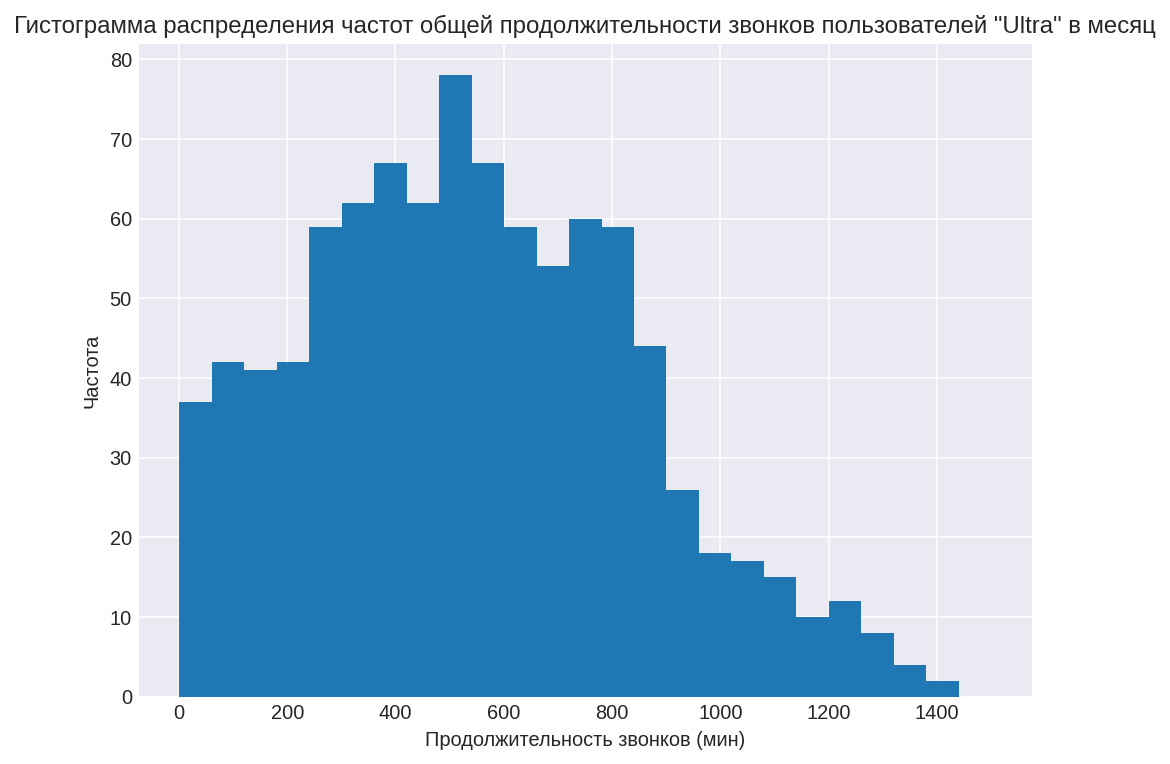

In [40]:
df_ultra['tot_duration'].hist(bins=25, range=(1, 1500))
plt.title('Гистограмма распределения частот общей продолжительности звонков пользователей "Ultra" в месяц')
plt.xlabel('Продолжительность звонков (мин)')
plt.ylabel('Частота');

Датасет скошен влево. Распределение не похоже на нормальное, поскольку слево оно ограничено нулем (значений меньше быть не может).

Посчитаем, какой процент данных мы не включили в выборку для анализа гистограммы.

In [41]:
len(df_ultra.query('1 > tot_duration or tot_duration > 1500'))/len(df_ultra)*100

4.060913705583756

Исключены из гистограммы примерно 4% данных (в основном за счет нулевых значений).

Проверим распределение на нормальность с помощью `distplot` - графика оценки одномерного распределения по выборке. 

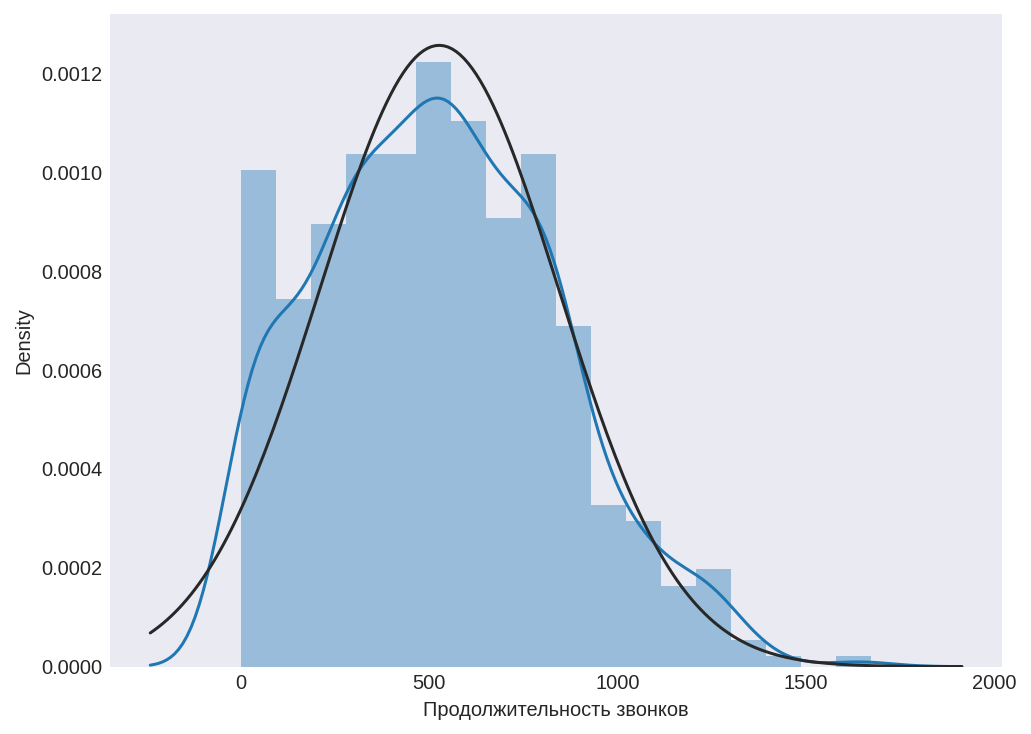

In [42]:
sns.distplot(df_ultra['tot_duration'], axlabel='Продолжительность звонков', fit=st.norm);

Распределение не является нормальным, но приближено к нему.

**Количество звонков**

Установим ограничение значений при построениии гистограммы: не будем включать нулевые значения (абонент не использовал звонки в этом месяце) и значения выше 200, так как они являются нетипичными.

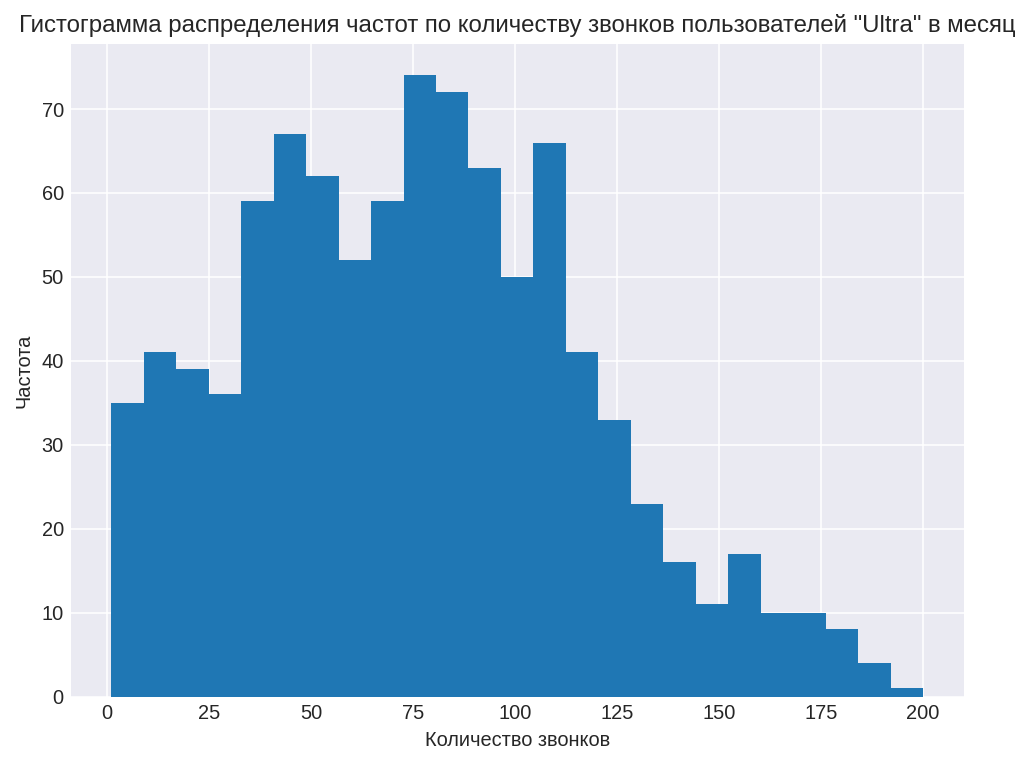

In [43]:
df_ultra['calls_count'].hist(bins=25, range=(1,200));
plt.title('Гистограмма распределения частот по количеству звонков пользователей "Ultra" в месяц')
plt.xlabel('Количество звонков')
plt.ylabel('Частота');

Мы получили скошенный влево датасет, с распределением, не похожим на нормальное, поскольку слево оно ограничено нулем (значений меньше быть не может).

Посчитаем, какой процент данных мы не включили в выборку для анализа гистограммы.

In [44]:
len(df_ultra.query('1 > calls_count or calls_count > 200'))/len(df_ultra)*100

3.654822335025381

Исключены из гистограммы примерно 3,7% данных (в основном за счет нулевых значений).

Проверим распределение на нормальность с помощью `distplot` - графика оценки одномерного распределения по выборке. 

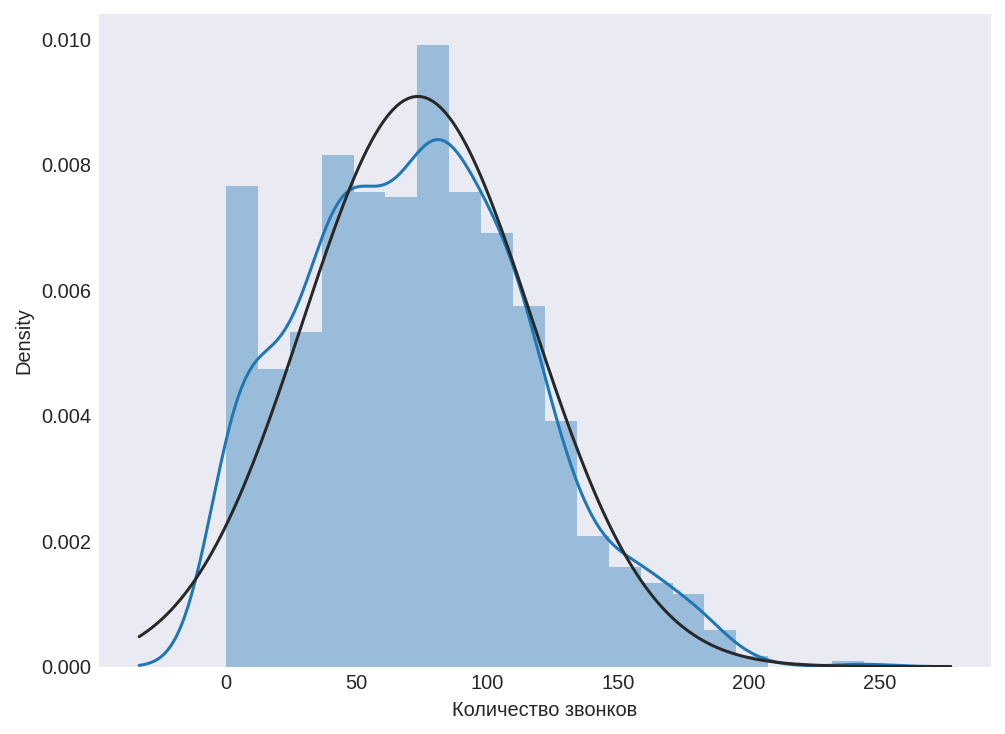

In [45]:
sns.distplot(df_ultra['calls_count'], axlabel='Количество звонков', fit=st.norm);

Распределение не является нормальным, но с некоторыми нюансами приближено к нему. 

**Количество сообщений**

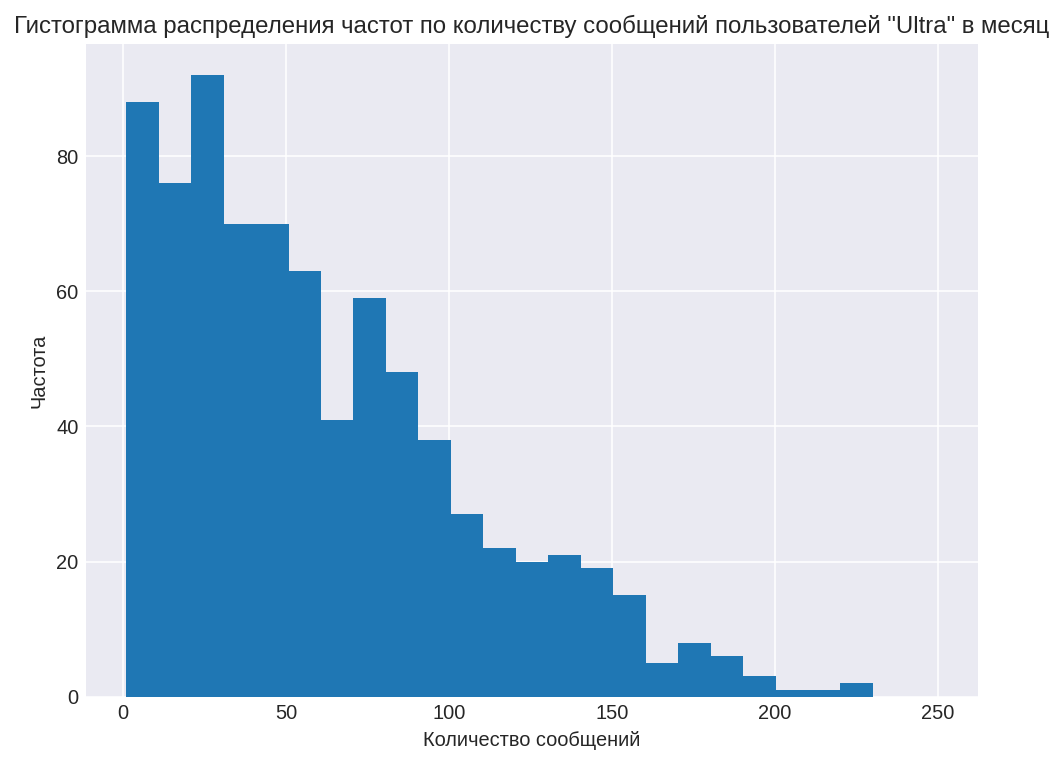

In [46]:
df_ultra['message_count'].hist(bins=25, range=(1,250)); # исключим из диапазона тех, кто не пользовался сообщениями
plt.title('Гистограмма распределения частот по количеству сообщений пользователей "Ultra" в месяц')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота');

Распределение не является нормальным. 

**Количество трафика**

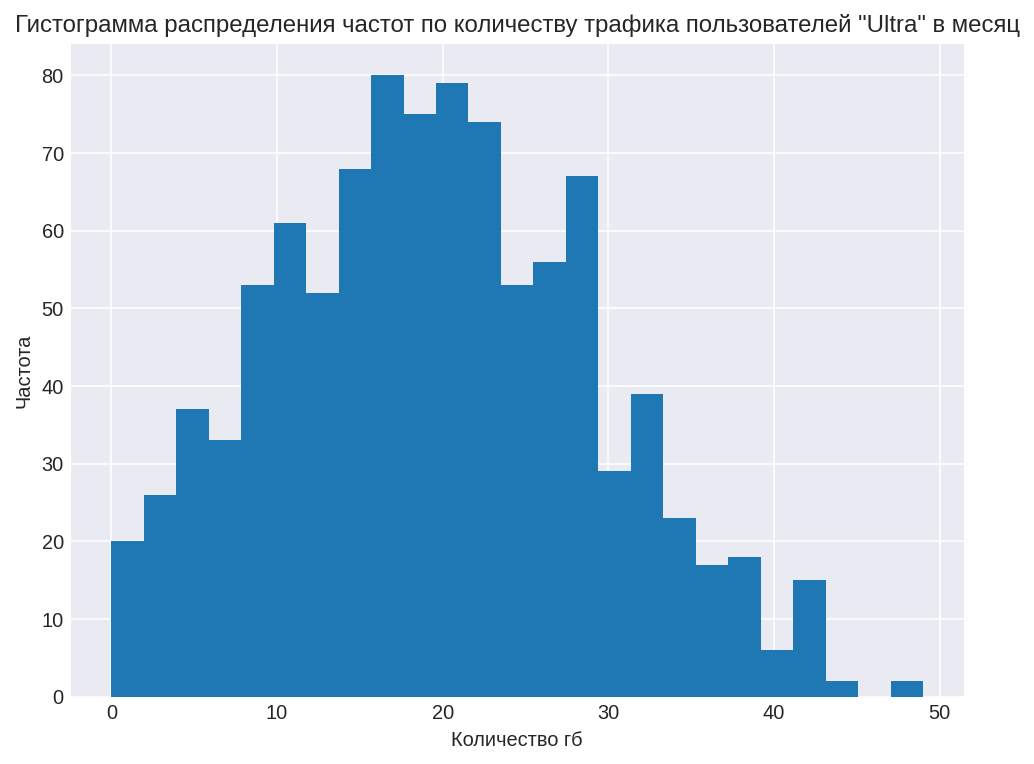

In [47]:
df_ultra['month_gb_used'].hist(bins=25); 
plt.title('Гистограмма распределения частот по количеству трафика пользователей "Ultra" в месяц')
plt.xlabel('Количество гб')
plt.ylabel('Частота');

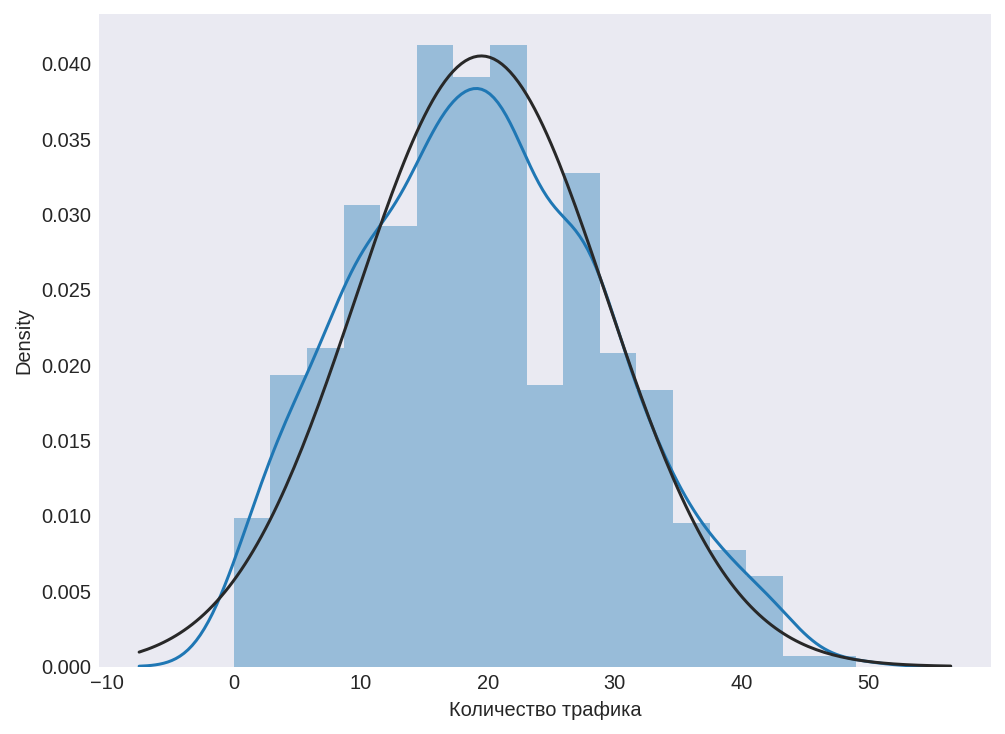

In [48]:
sns.distplot(df_ultra['month_gb_used'], axlabel='Количество трафика', fit=st.norm);

Распределение приближено к нормальному, скошено влево.

**Выручка**

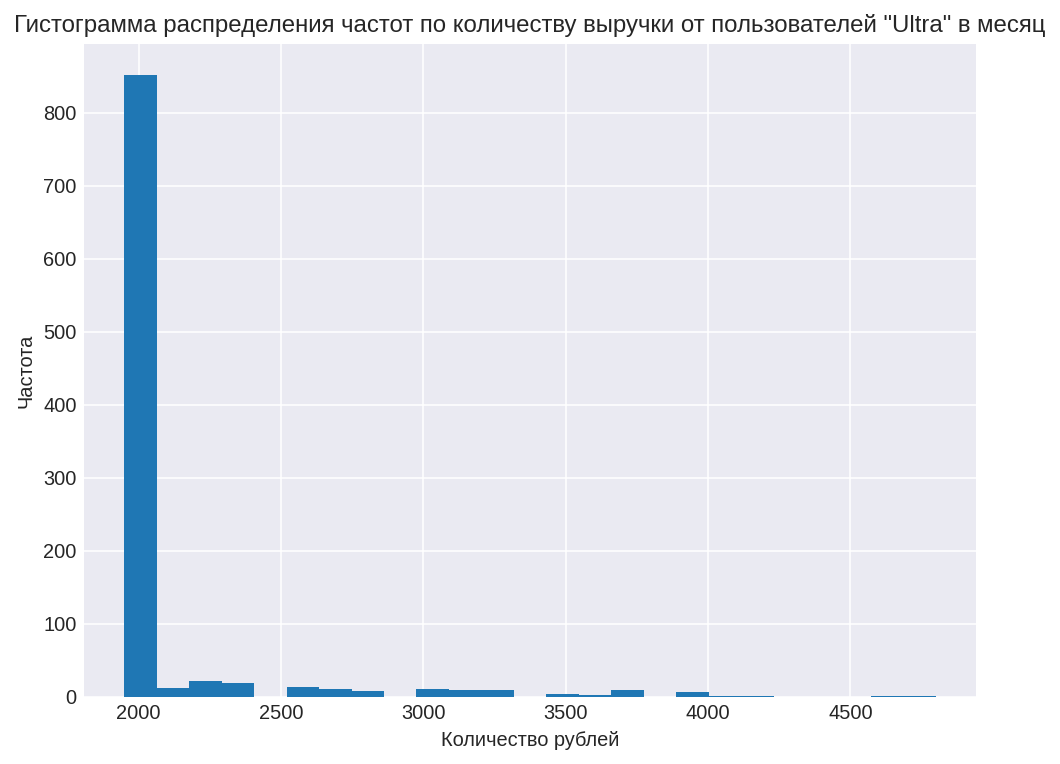

In [49]:
df_ultra['profit'].hist(bins=25);
plt.title('Гистограмма распределения частот по количеству выручки от пользователей "Ultra" в месяц')
plt.xlabel('Количество рублей')
plt.ylabel('Частота');

Распределение не является нормальным. Основная масса пользователей приносит около 2000 руб в месяц. 

#### Пользователи "Smart"

**Общая продолжительность звонков**

Установим ограничение значений при построениии гистограммы: не будем включать нулевые значения (абонент не дозвонился и мог совершать ряд таких попыток, пока разговор не состоялся).

Процент исключенных из построениея значений: 0.3589053387169134


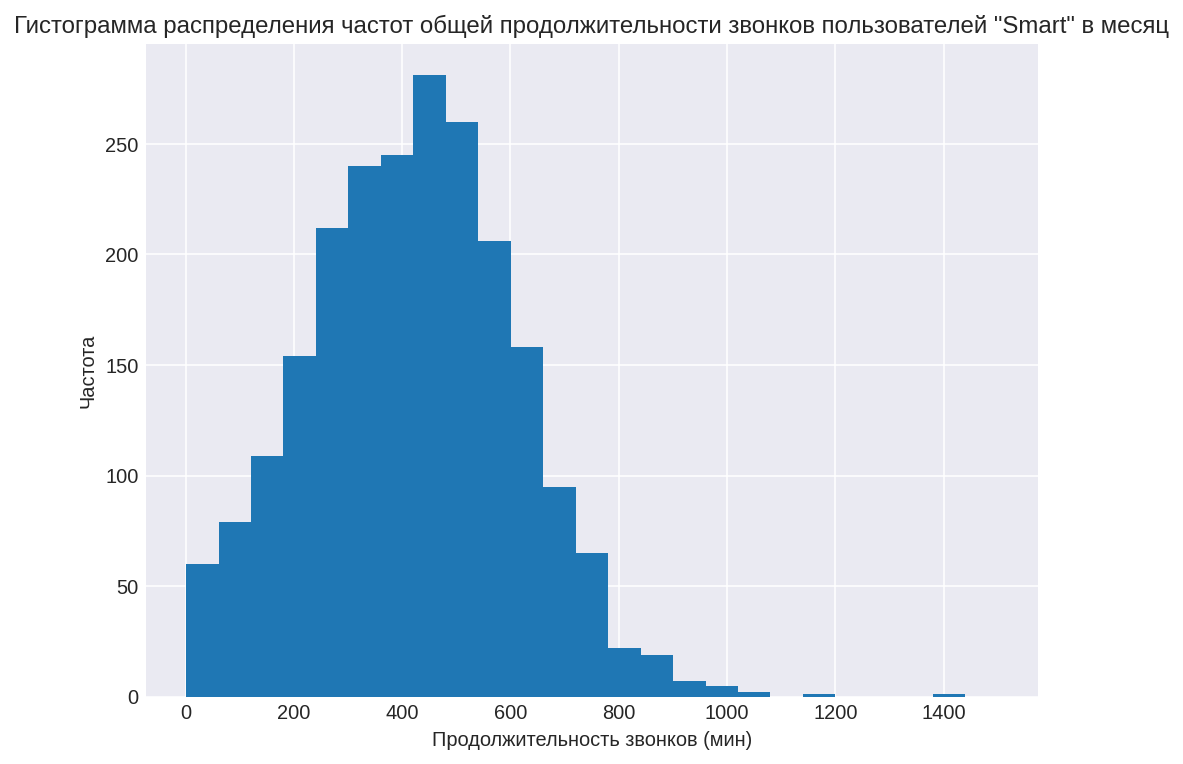

In [50]:
df_smart['tot_duration'].hist(bins=25, range=(1, 1500))
plt.title('Гистограмма распределения частот общей продолжительности звонков пользователей "Smart" в месяц')
plt.xlabel('Продолжительность звонков (мин)')
plt.ylabel('Частота');
print ('Процент исключенных из построениея значений:', len(df_smart.query('1 > tot_duration'))/len(df_smart)*100)

Датасет скошен влево. Распределение приближено к нормальному. 

Проверим распределение на нормальность с помощью `distplot` - графика оценки одномерного распределения по выборке. 

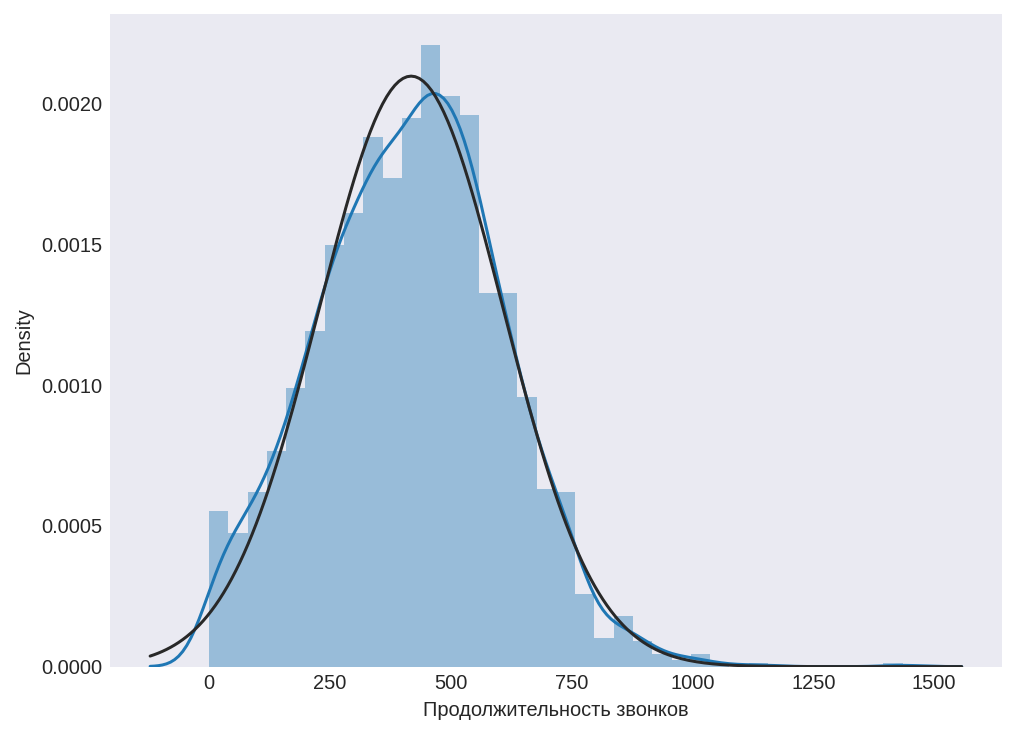

In [51]:
sns.distplot(df_smart['tot_duration'], axlabel='Продолжительность звонков', fit=st.norm);

Распределение близко к нормальному. 

**Количество звонков**

Процент исключенных из построениея значений: 0.31404217137729923


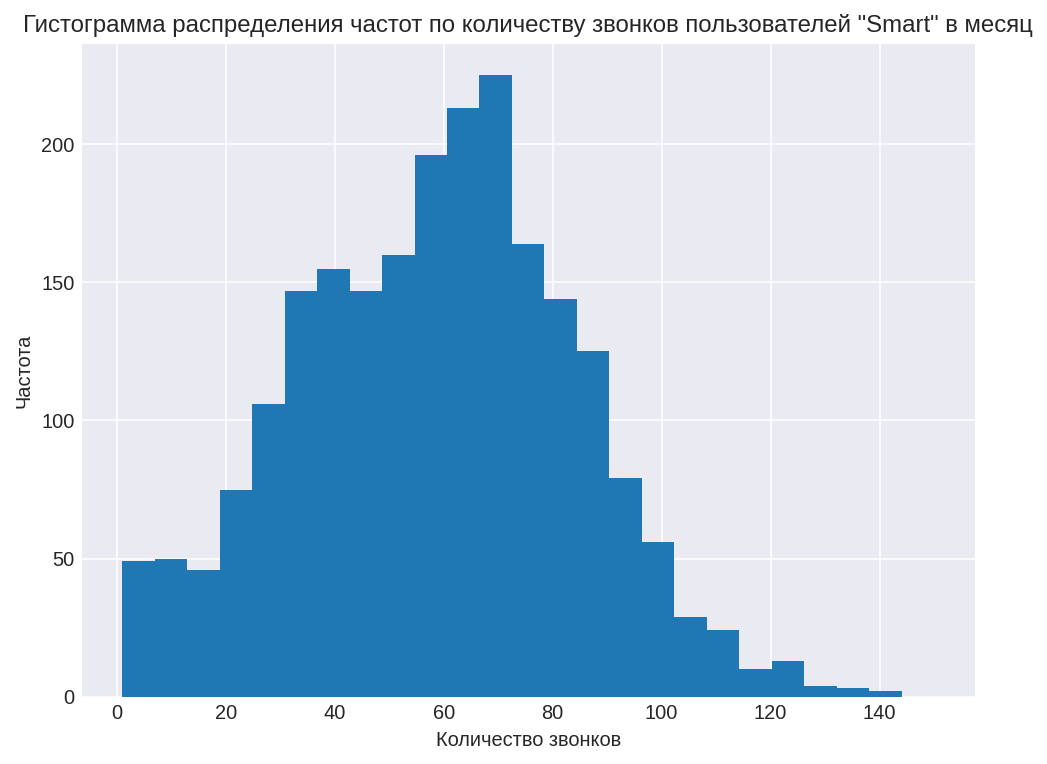

In [52]:
df_smart['calls_count'].hist(bins=25, range=(1, 150));
plt.title('Гистограмма распределения частот по количеству звонков пользователей "Smart" в месяц')
plt.xlabel('Количество звонков')
plt.ylabel('Частота');
print ('Процент исключенных из построениея значений:', 
       len(df_smart.query('1 > calls_count or calls_count > 150'))/len(df_smart)*100)

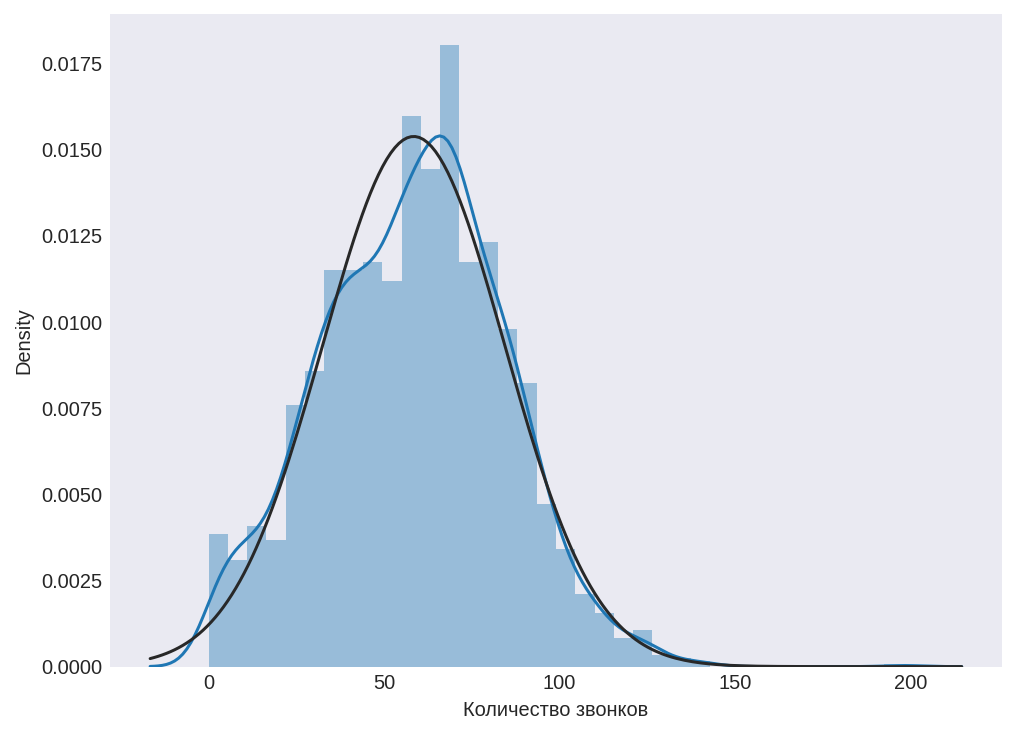

In [53]:
sns.distplot(df_smart['calls_count'], axlabel='Количество звонков', fit=st.norm);

Распределение близко к нормальному.

**Количество сообщений**

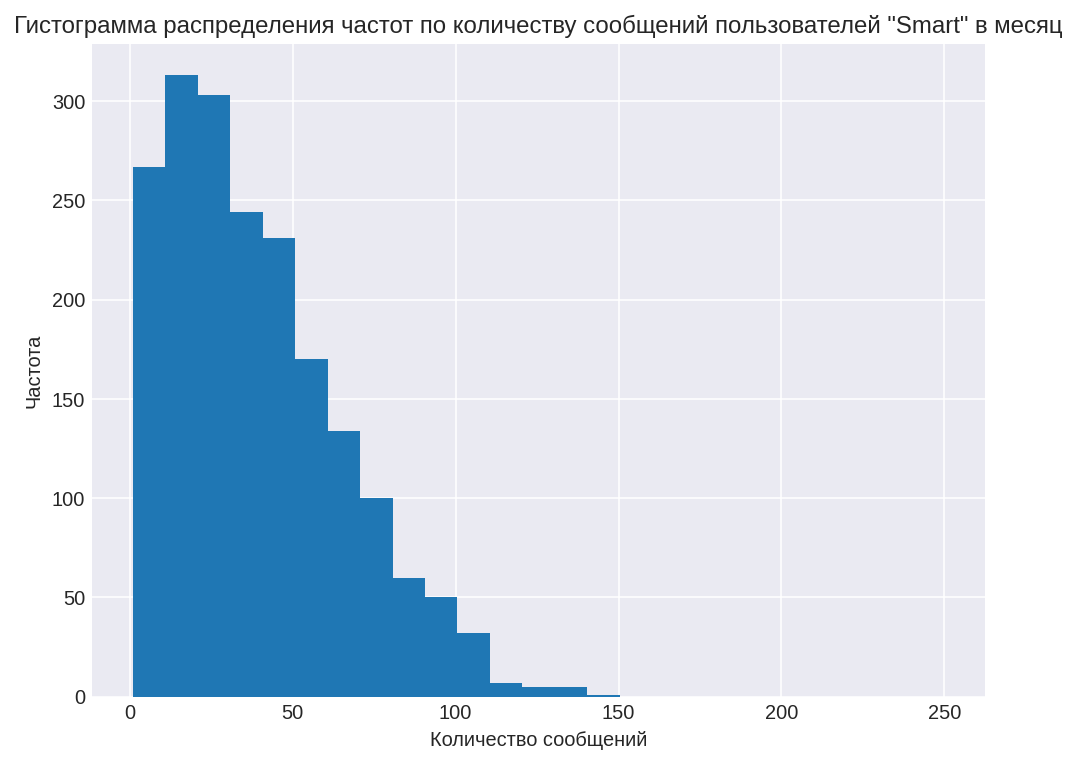

In [54]:
df_smart['message_count'].hist(bins=25, range=(1,250)); # исключим из диапазона тех, кто не пользовался сообщениями
plt.title('Гистограмма распределения частот по количеству сообщений пользователей "Smart" в месяц')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота');

Распределение не является нормальным. Частоты плавно убывают при увеличении числа сообщений в месяц.

**Количество трафика**

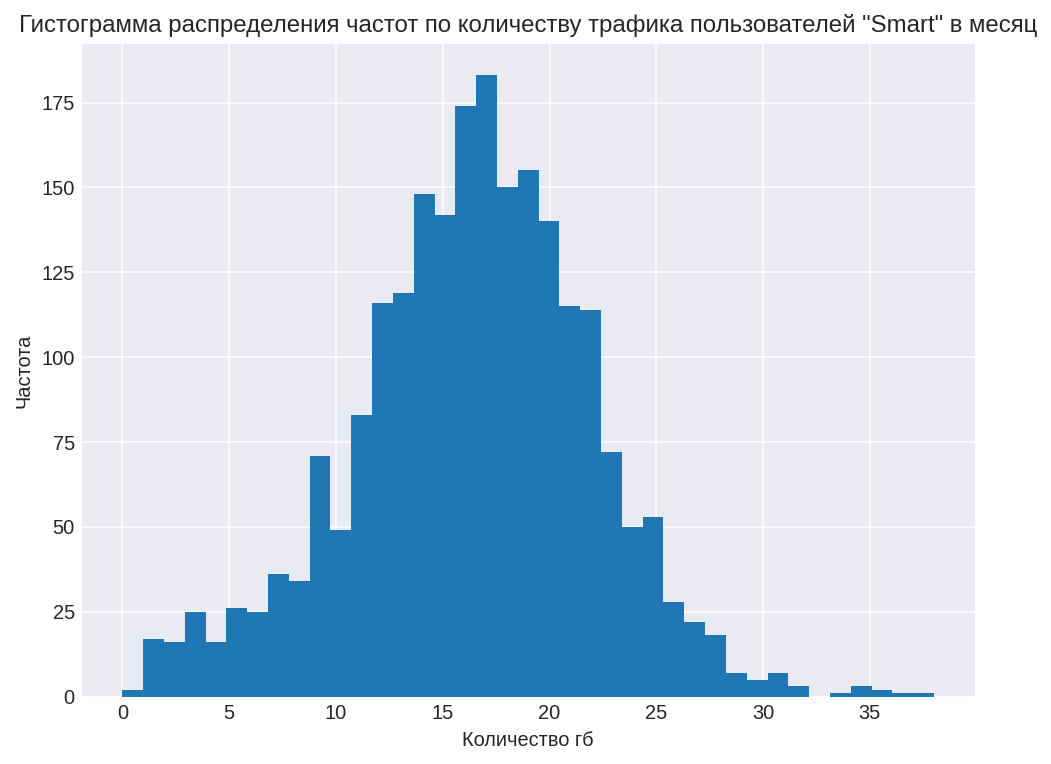

In [55]:
df_smart['month_gb_used'].hist(bins=39); 
plt.title('Гистограмма распределения частот по количеству трафика пользователей "Smart" в месяц')
plt.xlabel('Количество гб')
plt.ylabel('Частота');

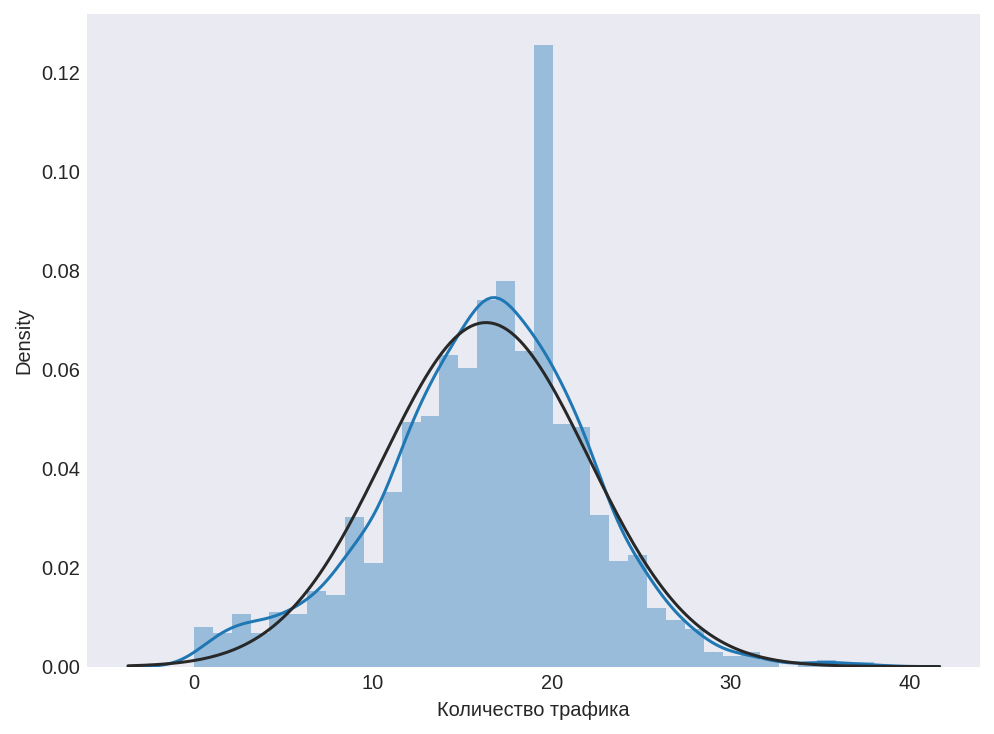

In [56]:
sns.distplot(df_smart['month_gb_used'], axlabel='Количество трафика', fit=st.norm);

Распределение приближено к нормальному.

**Выручка**

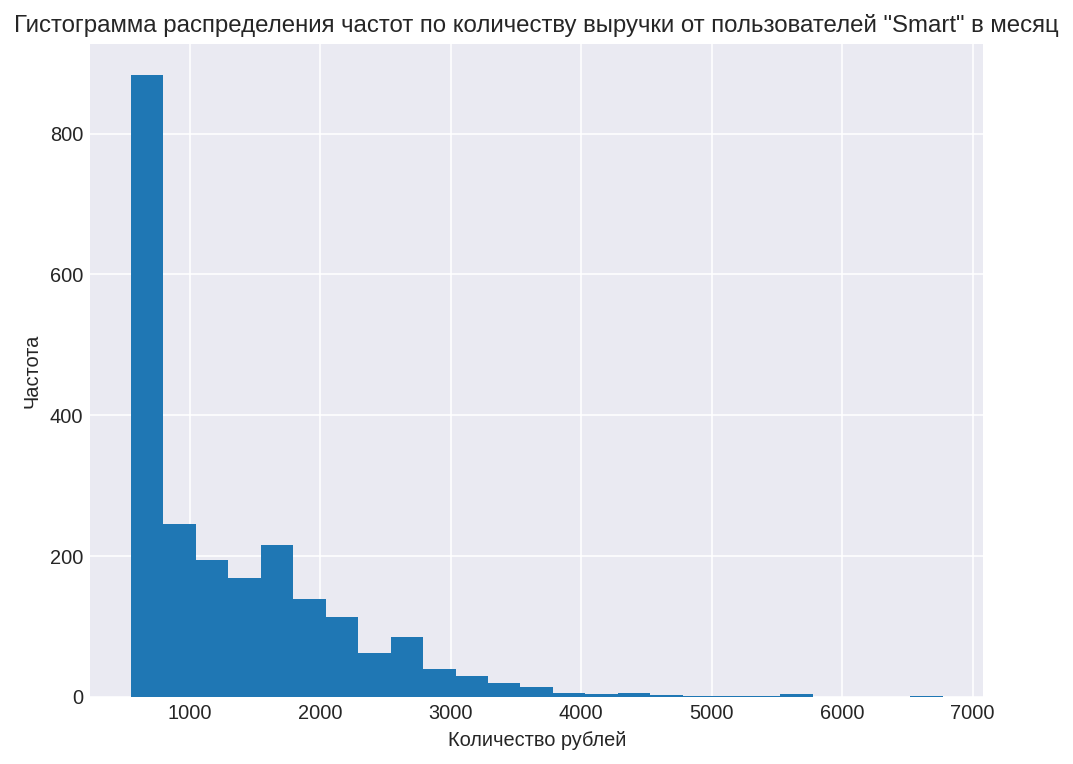

In [57]:
df_smart['profit'].hist(bins=25);
plt.title('Гистограмма распределения частот по количеству выручки от пользователей "Smart" в месяц')
plt.xlabel('Количество рублей')
plt.ylabel('Частота');

Распределение не является нормальным. Большинство пользователей данного тарифа приносят компании около 550 руб. в месяц (базовую плату за тариф). 

### Вывод

В данных представлено в 2 раза больше пользователей тарифа "Smart", чем пользователей тарифа "Ultra". 

Показатели среднего, дисперсии и стандартного отклонения больше для пользователей тарифа "Ultra".

Распределение показателей длительности и количества звонков и интернет-трафика условно напоминают нормальные, тогда как показатели количества сообщений и выручки распределены иначе. Ближе к нормальным распределения показателей у пользователей тарифа "Smart" за счет большего числа наблюдений и меньшего разброса значений.  

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт»

Сформулируем гипотезы для проверки.
* Н0 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова
* Н1 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Убедимся, что один и тот же пользователь не входит в разные выборки.

In [58]:
users_ultra = df_ultra['user_id'].unique()
df_smart.query('user_id in @users_ultra')

,user_id,month,tot_duration,calls_count,message_count,month_gb_used,tariff,city,profit


Мы можем утверждать, что перед нами независимые выборки пользователей. Однако распределение их значений не является нормальным, поэтому применим непараметрический тест Манна-Уитни. 

Уровень значимости:  α=0.05 

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости  α=0.05 , то нулевую гипотезу о равенстве средней выручки отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [59]:
alpha = .05
results = st.mannwhitneyu(df_ultra['profit'], df_smart['profit'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.9803845594554806e-187
Отвергаем нулевую гипотезу


Итак, на уровне значимости 0,05 нам следует отвергнуть нулевую гипотезу и принять альтернативную - "Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Проверим теперь еще одно предположение о том, что выручка пользователей тарифа "Ultra" больше средней выручки пользователей тарифа "Smart".

Сформулируем гипотезы для проверки.
* Н0 - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова
* Н1 - Cредняя выручка пользователей тарифа «Ультра» больше средней выручки пользователей тарифа "Смарт" 


In [60]:
results = st.mannwhitneyu(df_ultra['profit'], df_smart['profit'], alternative='greater')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  9.901922797277403e-188
Отвергаем нулевую гипотезу


Итак, на уровне значимости 0,05 верна гипотеза, согласно которой, средняя выручка пользователей тарифа «Ультра» больше средней выручки пользователей тарифа "Смарт".

### Cредняя выручка пользователей из Москвы и из других регионов.

In [61]:
df_msk = df.query('city == "Москва"')
df_regions = df.query('city != "Москва"')
df_regions['profit'].mean()

1524.9362274298885

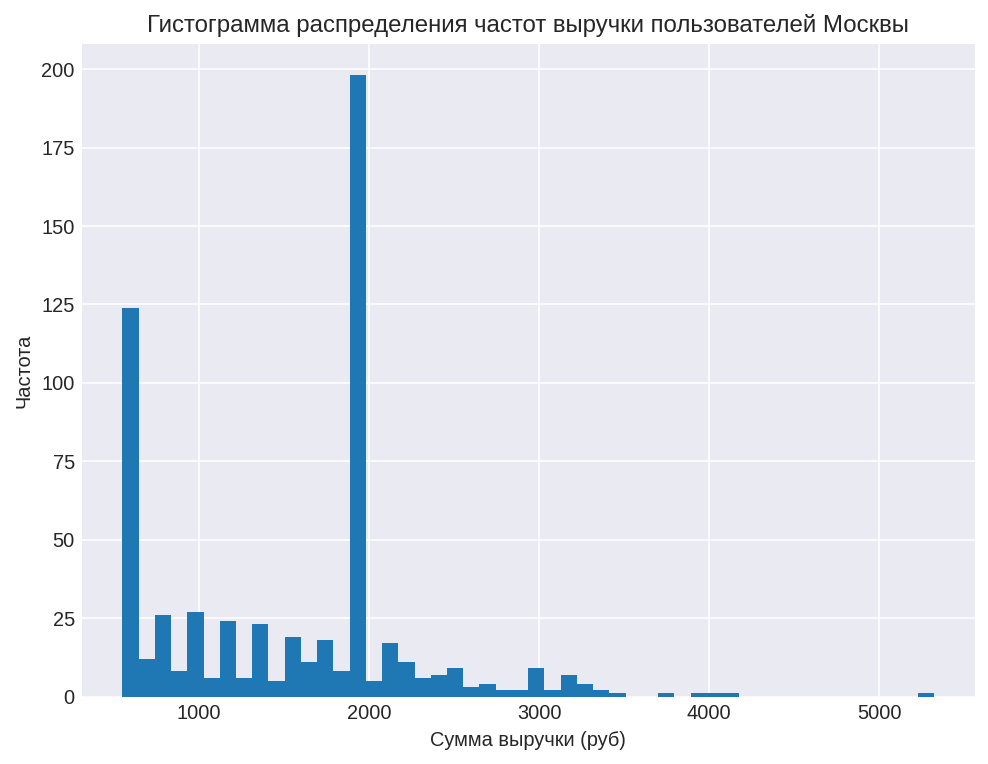

In [62]:
df_msk['profit'].hist(bins=50);
plt.title('Гистограмма распределения частот выручки пользователей Москвы')
plt.xlabel('Сумма выручки (руб)')
plt.ylabel('Частота');

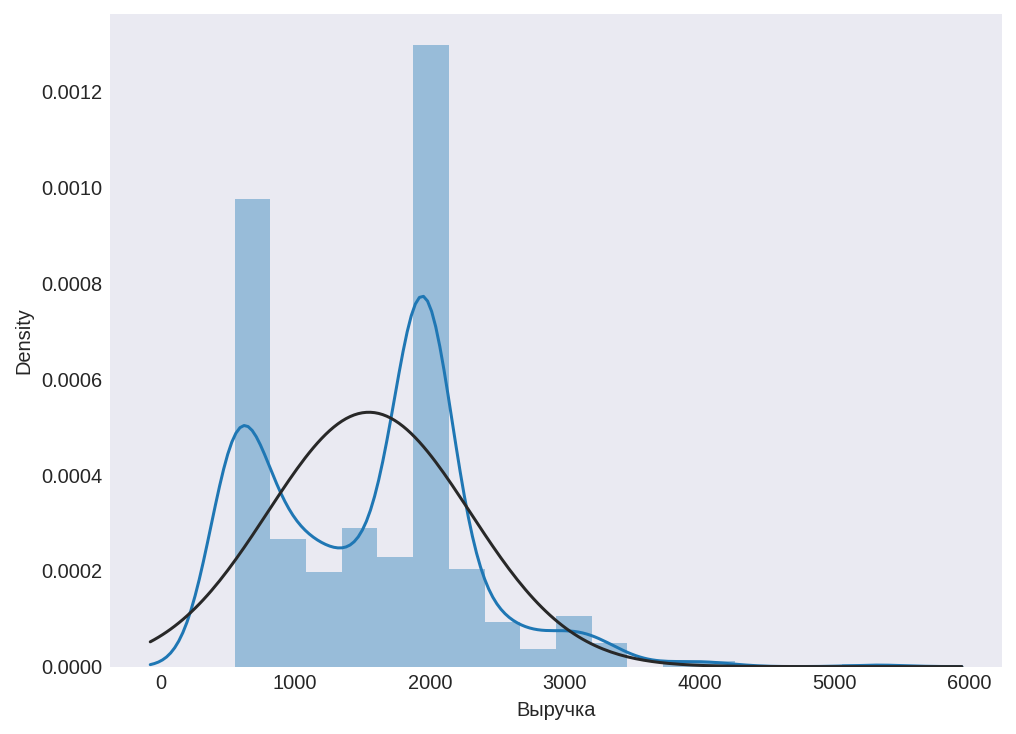

In [63]:
sns.distplot(df_msk['profit'], axlabel='Выручка', fit=st.norm);

В распределении две вершины, оно не близко к нормальному.

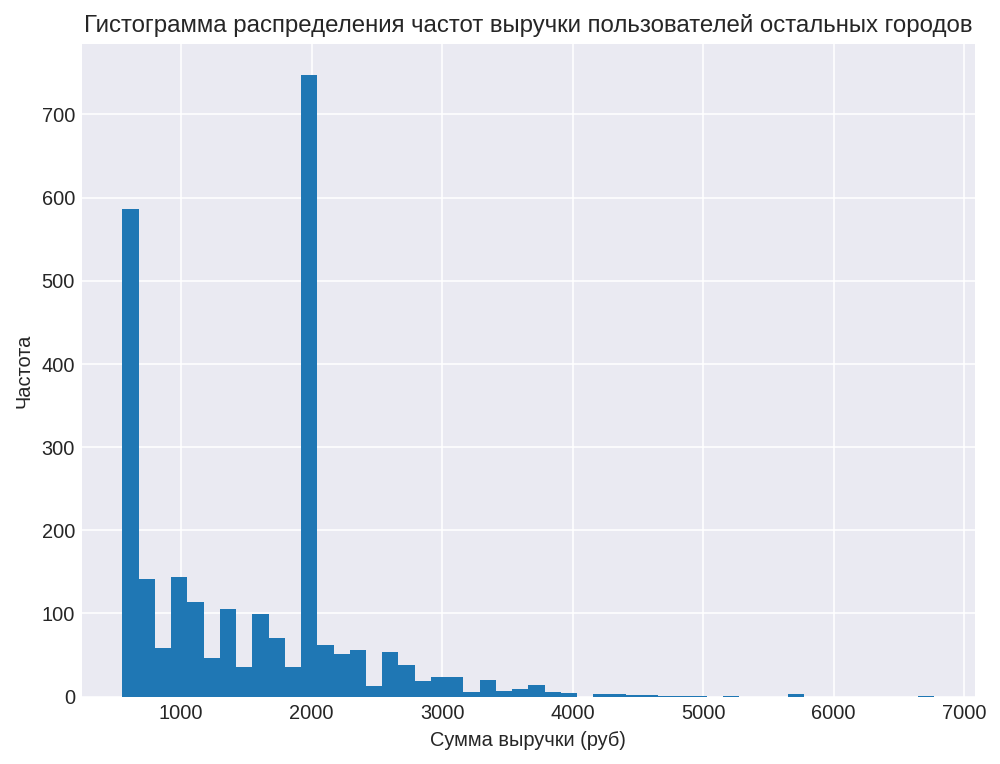

In [64]:
df_regions['profit'].hist(bins=50);
plt.title('Гистограмма распределения частот выручки пользователей остальных городов')
plt.xlabel('Сумма выручки (руб)')
plt.ylabel('Частота');

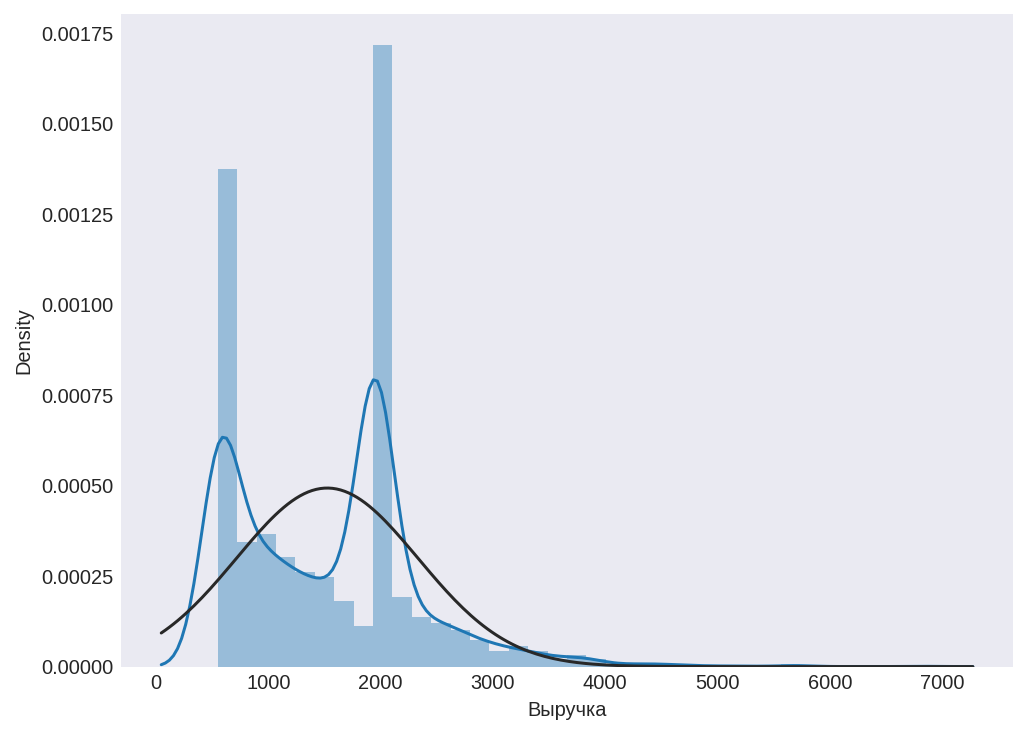

In [65]:
sns.distplot(df_regions['profit'], axlabel='Выручка', fit=st.norm);

В распределении две вершины, оно не близко к нормальному.

Мы можем утверждать, что перед нами независимые выборки пользователей. Однако распределение их значений не является нормальным, поэтому применим непараметрический тест Манна-Уитни. 

Уровень значимости:  α=0.05 

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости  α=0.05 , то нулевую гипотезу о равенстве средней выручки отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Сформулируем гипотезы:
* Н0 - Cредняя выручка пользователей Москвы и остальных городов одинакова
* Н1 - Cредняя выручка пользователей Москвы и остальных городов различается


In [66]:
alpha = .05
results = st.mannwhitneyu(df_msk['profit'], df_regions['profit'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.37423394910366004
Не получилось отвергнуть нулевую гипотезу


Итак, на уровне значимости 0,05 верна гипотеза, согласно которой, средняя выручка пользователей Москвы и остальных городов одинакова.

### Вывод

Гипотеза о том, что "Cредняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова" должна быть отвергнута для уровня значимости 0,05 и принята альтернативная гипотеза, согласно которой "Средняя выручка пользователей тарифа «Ультра» больше средней выручки пользователей тарифа "Смарт""

Гипотеза, согласно которой "Cредняя выручка пользователей Москвы и остальных городов одинакова" на текущих данных должна быть принята для уровня значимости 0,05.

## Общий вывод

Представленная информация о 500 пользователях оператора связи «Мегалайн» за 2018 год проанализирована. 
Обнаружено, что в представленных данных пользователей тарифа "Smart" в 2 раза больше, чем пользователей тарифа "Ultra". 

Пользователи Ультра в среднем совершают больше звонков по числу и продолжительности, отправляют больше смс и используют больше интернета. Средние показатели группы пользователей "Ultra" выше, чем в группе пользователей "Smart": 
* по длительности звонков и их количеству на 20% , 
* по количеству сообщений на 32%, 
* по использованию интернета на 17%,
* по выручке компании-оператора на 38%

Проверены и подтверждены на уровне значимости 0,05 гипотезы о том, что 
* средняя выручка пользователей тарифа «Ультра» больше средней выручки пользователей тарифа "Смарт"
* средняя выручка пользователей Москвы и остальных городов одинакова

Таким образом, можно утверждать, что на наших данных пользователи тарифа "Ультра" приносят больше прибыли оператору связи «Мегалайн». А также то, что выручка пользователей столицы и остальных городов России не демонстрирует существенных различий. 

Исходя из этого можно предположить большую эффективность вложения рекламного бюджета в тариф "Ультра" и отсутствие необходимости сегрегации жителей Москвы и остальных городов при планировании рекламной кампании. 